# Library

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import seaborn as sns
from collections import Counter
import emoji
import re
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [5]:
is_cuda_available = torch.cuda.is_available()

print(f"Is CUDA available? {is_cuda_available}")

if is_cuda_available:
    # Print details about the GPU
    print(f"CUDA version used by PyTorch: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("\nPyTorch cannot find a CUDA-enabled GPU.")
    print("This is likely because you installed the CPU-only version of PyTorch.")

Is CUDA available? True
CUDA version used by PyTorch: 12.8
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


# EDA

In [6]:
MODEL = "xlm-roberta-base"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Length (Token)

In [8]:
data = pd.read_csv("Amazon_Fashion_3_2_core.csv")
data.dropna(inplace=True)
data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Great socks for the gym or for your house,Nice socks. They say they are for yoga/pilates...,[],B0856TH4LK,B0856TH4LK,AFSKPY37N3C43SOI5IEXEK5JSIYA,2020-04-18 10:24:18.621,0,False
1,5,"Nice, warm merino wool socks!",I absolutely love these socks. Super soft and ...,[],B07ZWZ2595,B07ZWZ2595,AFSKPY37N3C43SOI5IEXEK5JSIYA,2020-01-19 11:23:39.201,0,False
2,4,"Nice jacket, runs a little small","Not a bad rain jacket but, at the time I am wr...",[],B07NY72H7W,B07NY72H7W,AFSKPY37N3C43SOI5IEXEK5JSIYA,2019-08-12 19:43:59.659,0,False
3,5,Great biking gloves for newbies or expert riders,"Great cycling gloves. Well made, form fitting ...",[],B07NX5RHZ2,B07NX5RHZ2,AFSKPY37N3C43SOI5IEXEK5JSIYA,2019-06-24 01:00:44.117,0,False
4,3,Quality made but runs small,"Nicely made, lightweight windbreaker. Easily f...",[],B07H92ZCQ9,B07H92ZCQ9,AFSKPY37N3C43SOI5IEXEK5JSIYA,2019-02-09 11:46:44.435,0,False


In [9]:
token_lengths = [len(tokenizer.encode(text)) for text in data['text']]

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


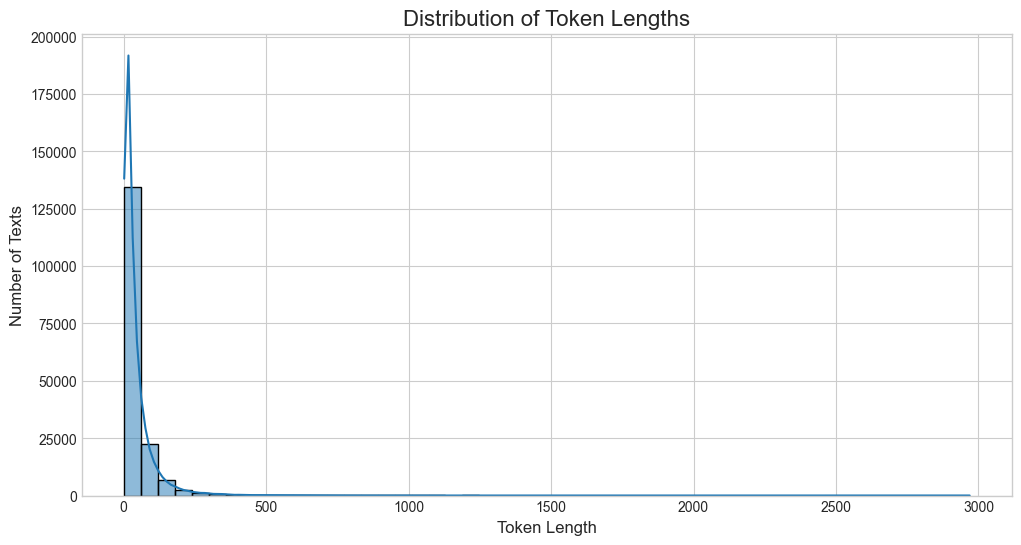

In [10]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, bins=50, kde=True)
plt.title('Distribution of Token Lengths', fontsize=16)
plt.xlabel('Token Length', fontsize=12)
plt.ylabel('Number of Texts', fontsize=12)
plt.show()

In [11]:
data['text_length'] = token_lengths
data[['text_length']].describe()

,text_length
count,168631.000000
mean,43.675700
std,60.944873
min,2.000000
25%,11.000000
50%,25.000000
75%,52.000000
max,2969.000000


We can see that here the data length is very skewed, while having the mean of 43 and Q2 of 25 meaning that we will need to clean the data later because of the outlier.


BERT model also just able to handle 512 token at a time, this information ensure us that there are not many data is located at token with size more than 512. That way we can maintain huge number of data while maintaining the model requirements

# Basic Distribution

In [17]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168631 entries, 0 to 168727
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   rating             168631 non-null  int64 
 1   title              168631 non-null  object
 2   text               168631 non-null  object
 3   images             168631 non-null  object
 4   asin               168631 non-null  object
 5   parent_asin        168631 non-null  object
 6   user_id            168631 non-null  object
 7   timestamp          168631 non-null  object
 8   helpful_vote       168631 non-null  int64 
 9   verified_purchase  168631 non-null  bool  
 10  text_length        168631 non-null  int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 14.3+ MB


In [19]:
data.describe()

,rating,helpful_vote,text_length
count,168631.000000,168631.000000,168631.000000
mean,4.085880,0.797012,43.675700
std,1.303261,5.848504,60.944873
min,1.000000,0.000000,2.000000
25%,3.000000,0.000000,11.000000
50%,5.000000,0.000000,25.000000
75%,5.000000,0.000000,52.000000
max,5.000000,667.000000,2969.000000


## Rating distribution

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13452\3944166544.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data= data, palette="Set2")


Text(0.5, 1.0, 'Rating Distribution')

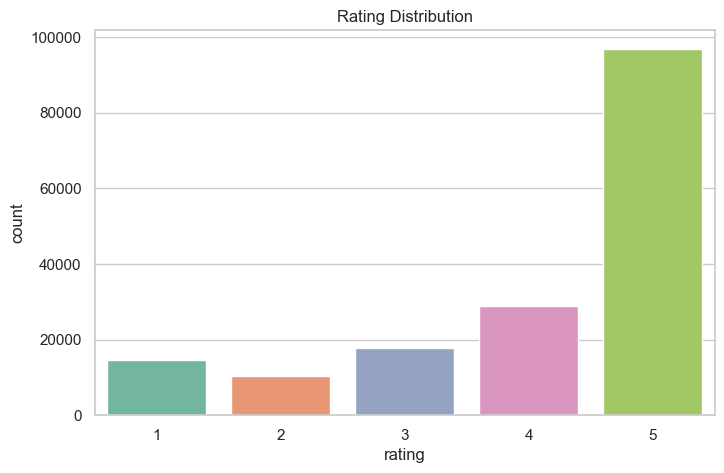

In [20]:
plt.figure()
sns.countplot(x="rating", data= data, palette="Set2")
plt.title("Rating Distribution")

## Helpful votes

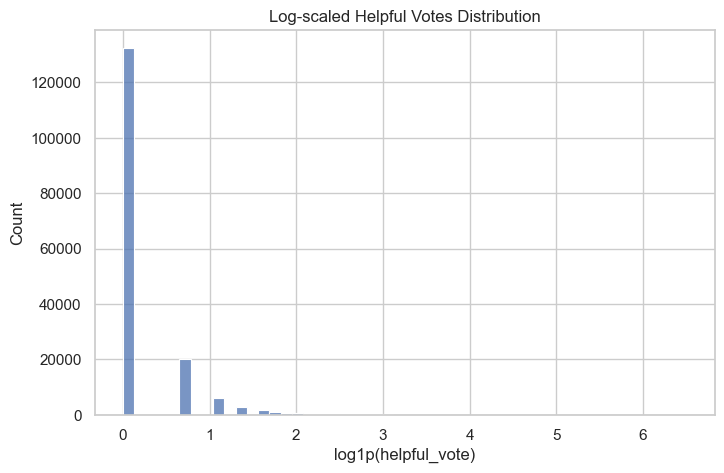

In [21]:
plt.figure()
sns.histplot(np.log1p(data["helpful_vote"]), bins=50)
plt.title("Log-scaled Helpful Votes Distribution")
plt.xlabel("log1p(helpful_vote)")
plt.show()

## verified purchase ration

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13452\2294081255.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="verified_purchase", data=data, palette="pastel")


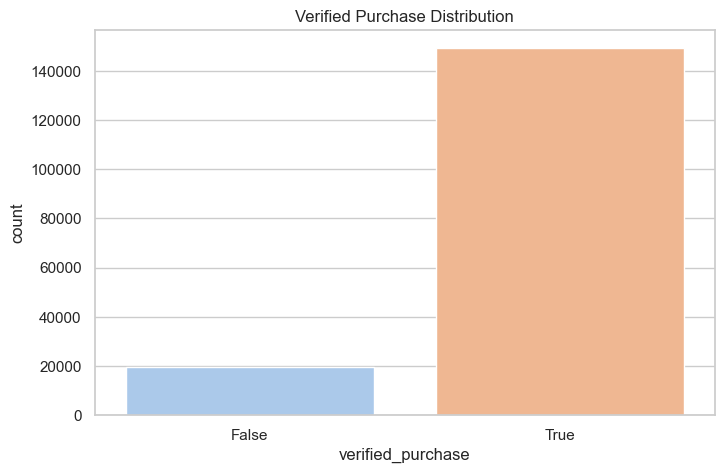

In [23]:
plt.figure()
sns.countplot(x="verified_purchase", data=data, palette="pastel")
plt.title("Verified Purchase Distribution")
plt.show()

# Temporal Pattern

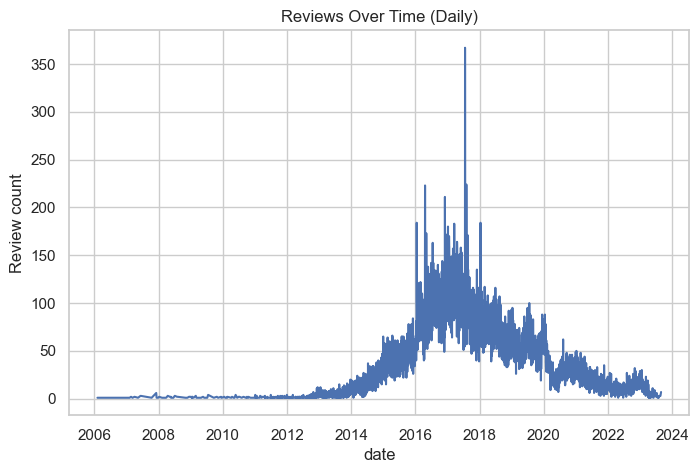

In [27]:
data["timestamp"] = pd.to_datetime(data["timestamp"], errors="coerce")
data["date"] = data["timestamp"].dt.date
daily_counts = data.groupby("date").size()
plt.figure()
daily_counts.plot()
plt.title("Reviews Over Time (Daily)")
plt.ylabel("Review count")
plt.show()

# User

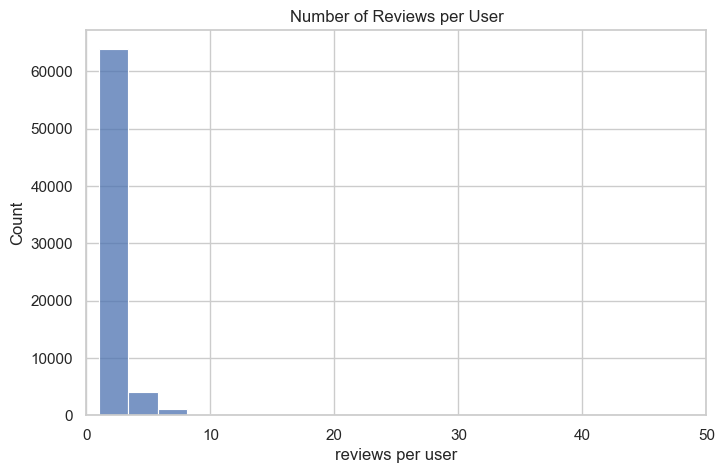

Top 10 most active users:
 user_id
AEYVPPWR4CIKWX4BGYKCBCDL2CZQ      120
AG73BVBKUOH22USSFJA5ZWL7AKXA      111
AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1    109
AGZZXSMMS4WRHHJRBUJZI4FZDHKQ       95
AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_2     80
AG3HKK7MIKRQ7DOTNDOE63X2WJGQ       60
AH5HSMUMRJRDWBPFDQ6G3EAAOSFQ       55
AGQIUTI7M4XUGCRV6E66FAOCX5PQ       53
AH665SQ6SQF6DXAGYIQFCX76LALA       48
AGIS3QL3LUEQWKF3YKHLLWDD5BJA       48
Name: count, dtype: int64


In [28]:
user_counts = data["user_id"].value_counts()
plt.figure()
sns.histplot(user_counts, bins=50)
plt.title("Number of Reviews per User")
plt.xlabel("reviews per user")
plt.xlim(0,50)  # clip for visibility
plt.show()

print("Top 10 most active users:\n", user_counts.head(10))

# Item stats

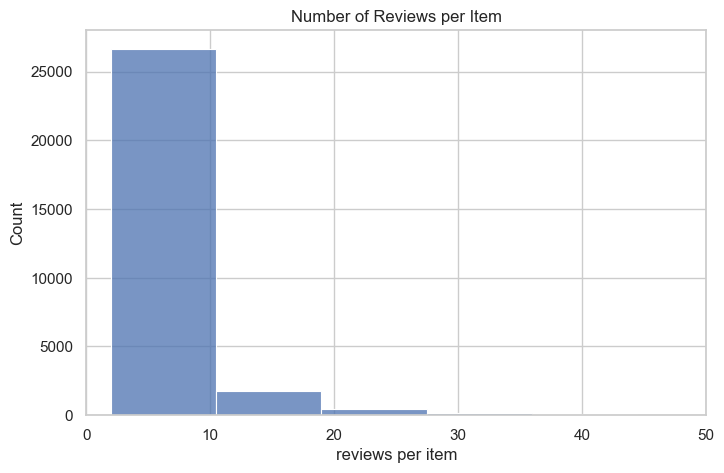

In [29]:
item_counts = data["asin"].value_counts()
plt.figure()
sns.histplot(item_counts, bins=50)
plt.title("Number of Reviews per Item")
plt.xlabel("reviews per item")
plt.xlim(0,50)
plt.show()

In [30]:
print("Top 10 most reviewed items:\n", item_counts.head(10))

Top 10 most reviewed items:
 asin
B000GAWSDG    426
B000FIS5U4    330
B017U1FDM6    241
B00ZIK4NH8    198
B00KA3TUNA    183
B00KA3VX62    181
B00UDF11O6    164
B00KA3VEG6    158
B0045H0L1W    157
B00KA3SRVG    156
Name: count, dtype: int64


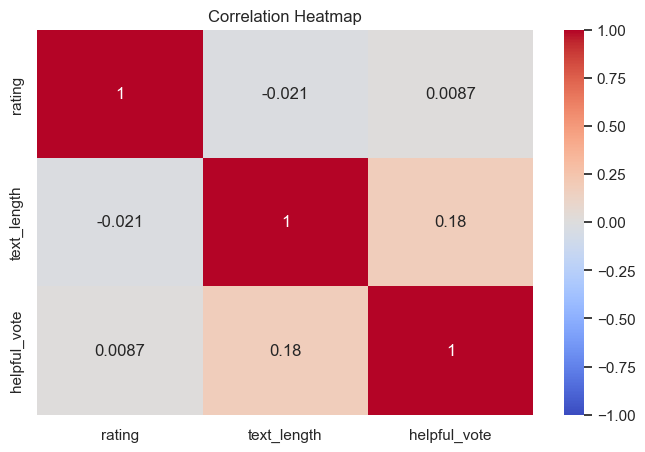

In [32]:
num_cols = ["rating","text_length","helpful_vote"]
plt.figure()
sns.heatmap(data[num_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13452\2424069585.py:20: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  plt.tight_layout()
c:\Users\lenovo\anaconda3\envs\text_mining\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


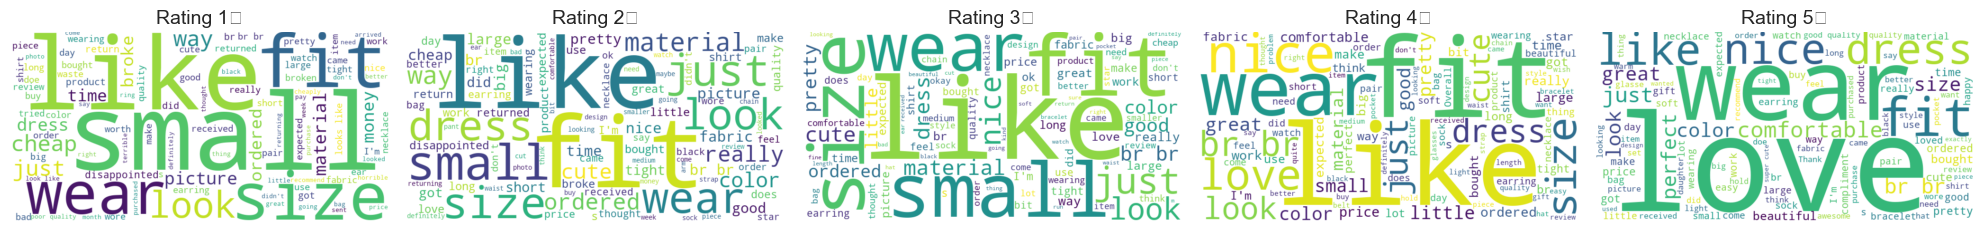

In [36]:
data["text"] = data["text"].fillna("").astype(str)

# iterate per rating
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for i, rating in enumerate(sorted(data["rating"].unique())):
    texts = " ".join(data.loc[data["rating"] == rating, "text"].tolist())
    wc = WordCloud(
        stopwords=ENGLISH_STOP_WORDS,
        background_color="white",
        max_words=100,
        width=800,
        height=400
    ).generate(texts)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Rating {rating}★", fontsize=14)

plt.tight_layout()
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13452\1448842229.py:31: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  plt.tight_layout()
c:\Users\lenovo\anaconda3\envs\text_mining\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


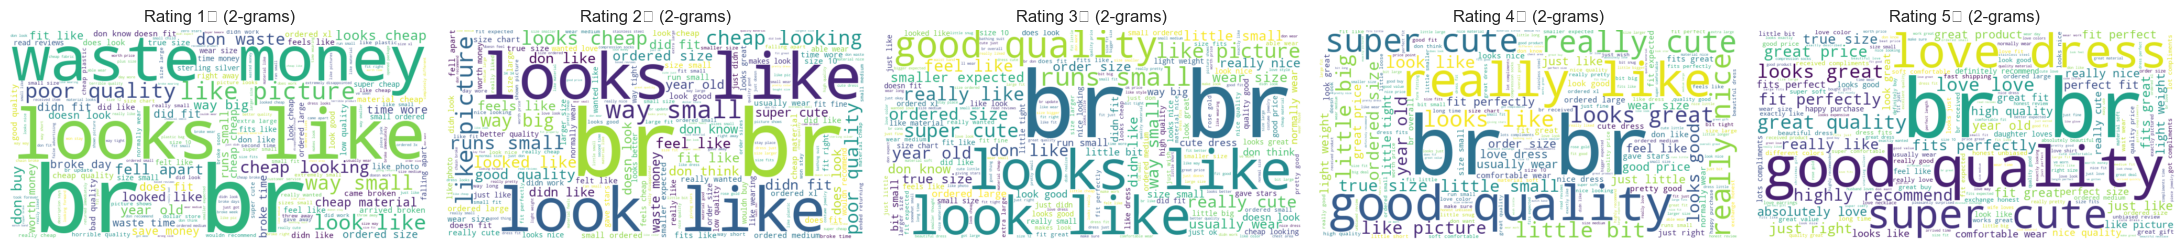

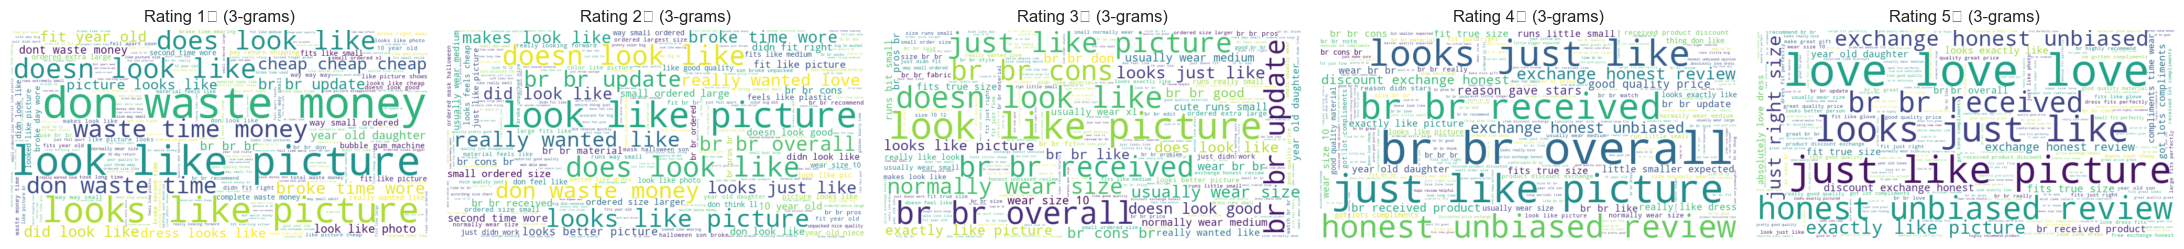

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generate_ngram_wordcloud(texts, ngram_range=(2,2), max_features=200):
    """
    Build a wordcloud from n-grams in a list of texts.
    """
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range, max_features=max_features).fit(texts)
    bag = vec.transform(texts)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = dict(sorted(words_freq, key=lambda x: x[1], reverse=True))
    
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words_freq)
    return wc

# Make sure text column is clean
data["text"] = data["text"].fillna("").astype(str)

# Plot per rating
for ngram in [(2,2),(3,3)]:
    fig, axes = plt.subplots(1, 5, figsize=(22, 6))
    for i, rating in enumerate(sorted(data["rating"].unique())):
        texts = data.loc[data["rating"] == rating, "text"].tolist()
        wc = generate_ngram_wordcloud(texts, ngram_range=ngram, max_features=200)
        
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].axis("off")
        axes[i].set_title(f"Rating {rating}★ ({ngram[0]}-grams)", fontsize=12)
    
    plt.tight_layout()
    plt.show()